## scMKL workshop
Here, we will run scMKL with a 10x Multiome (scRNA-seq and scATAC-seq) small lymphocytic lymphoma (SLL) dataset.

In [1]:
import scmkl
import numpy as np
import scanpy as sc
from muon import atac as ac
from scipy.sparse import load_npz

/home/exacloud/gscratch/CEDAR/vangordi/Miniconda3/envs/opt_scmkl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reading in data
data_dir = '/home/groups/CEDAR/scMKL/data/MCF7/'
x_fp = data_dir + 'MCF7_{}_scipy.npz'
vars_fp = data_dir + 'MCF7_{}_feature_names.npy'
labs_fp = data_dir + 'MCF7_cell_metadata.npy'

# RNA data
rna_x = load_npz(x_fp.format('RNA'))
rna_var = np.load(vars_fp.format('RNA'), allow_pickle=True)

# ATAC data
atac_x = load_npz(x_fp.format('ATAC'))
atac_var = np.load(vars_fp.format('ATAC'), allow_pickle=True)

# Cell labels
labs = np.load(labs_fp, allow_pickle=True)

## Getting a gene grouping
scMKL requires grouping dictionaries to calculate ***Z*** matrices. To find possible libraries containing gene sets for our classification task, we can use the `scmkl.find_candidates()` function.

In [59]:
# Terms that we want in group names
terms = [
    'breast', 'cancer', 'myc', 'brca', 
    'rad51', 'palb', 'mcf7', 't47d',
    'tumor', 'estrogen', 'esr'
    ]

# Terms we want to avoid
blist = [
    'progenitor', 'umbilical', 'tonsil', 
    'lung', 'intestine', 'spleen', 'bile',
    'liver', 'epithel', 'stem', 'pancreas',
    'breast', 'skin', 'stomach', 'colo', 
    'fetal', 'bone', 'heart', 'endothel'
    ]

scmkl.find_candidates(organism='human',
                      key_terms=terms,
                      blacklist=blist)

,Library,No. Gene Sets,No. Key Terms Matching,No. Blacklist Matching
0,Azimuth_2023,1241,1,811
1,Azimuth_Cell_Types_2021,341,0,7
2,Cancer_Cell_Line_Encyclopedia,967,58,540
3,CellMarker_2024,1134,74,627
4,CellMarker_Augmented_2021,1096,63,601
5,GO_Biological_Process_2025,5341,27,256
6,GO_Cellular_Component_2025,466,0,0
7,GO_Molecular_Function_2025,1174,7,7
8,KEGG_2021_Human,320,19,16
9,MSigDB_Hallmark_2020,50,4,3


Now that we have decided on a gene set library, we will pull and filter it with `scmkl.get_gene_groupings()`.

**NOTE:** Including `key_terms` or `blist` will filter output groups to only groups that contain one or more elements from `key_terms` and not `blist`. Additionally, including a list of gene names (from your dataset) will filter out groups that do not contain at least two genes from the input gene names as these groups would be filtered out in later steps of the workflow anyways. If you want the entire library only specify `lib_name` and `organism`.

In [60]:
gene_groups = scmkl.get_gene_groupings(lib_name='Reactome_Pathways_2024', 
                                       organism='human',
                                       key_terms=terms,
                                       blacklist=blist, 
                                       genes=rna_var)

print(f"There are {len(gene_groups)} groups in `gene_groups`")

There are 43 groups in `gene_groups`


## Creating a region grouping

While there are many ways to group regions, the fastest is to group regions by inferrered promotor of genes from gene groupings. To do this, we need a GTF file. If your features are aligned to GRCh38/hg38, the 'Homo_sapiens.GRCh38.114.chr.gtf.gz' GTF will work.

In [62]:
# Reading in GTF and filtering to protein coding genes
gtf_fp = data_dir + '../gencode.v32.primary_assembly.annotation.gtf.gz'
gtf = scmkl.read_gtf(gtf_fp, filter_to_coding=True)

# Using gene groupings and regions to create grouping dictionary
region_groups = scmkl.get_region_groupings(gtf, gene_groups, 
                                           feature_names=atac_var, 
                                           len_up=5000, 
                                           len_down=5000)

print(f"There are {len(region_groups)} groups in `region_groups`")

There are 43 groups in `region_groups`


In [63]:
med_regions = np.median([len(feats) for _, feats in region_groups.items()])

print(f"Median number of regions per group: {med_regions}")

Median number of regions per group: 40.0


## Creating scMKL formatted AnnData object
There are two functions for creating AnnData objects. `scmkl.create_adata()` takes a single-cell dataset separated into the matrix, feature names, and cell labels. `scmkl.format_adata()` takes an existing AnnData object and adds the required variables to run scMKL. There are different parameters depending on if the input data matrix is binary (ATAC) or non-binary (such as RNA, ADT, ect...). Function will also generate a random train/test split (80%/20%).

### Arguments
| Type | `scale_data` | `kernel_type` | `distance_metric` |
| ---- | ------------ | ------------- | ----------------- |
| non-binary | `True` | `'gaussian'` | `'euclidean'` |
| binary | `False` | `'laplacian'` | `'cityblock'` | 

In [64]:
rna_adata = scmkl.create_adata(rna_x, rna_var, labs, gene_groups, 
                           scale_data=True, 
                           kernel_type='gaussian', 
                           distance_metric='euclidean', 
                           D=100)

atac_adata = scmkl.create_adata(atac_x, atac_var, labs, region_groups,
                                scale_data=False,  
                                kernel_type='laplacian', 
                                distance_metric='cityblock', 
                                D=100)

# Combining modalities
adatas = [rna_adata, atac_adata]
names = ['RNA', 'ATAC']
tfidf_mask = [False, False]

combined_adata = scmkl.multimodal_processing(adatas, names, tfidf_mask)

Estimating sigma and calculating Z for RNA
Estimating sigma and calculating Z for ATAC


## Running scMKL

`scmkl.run()` will:

1) Estimate kernel widths (*σ*)
2) Calculate random fourier features (***Z***) for each group
3) Train a model for each for each alpha
4) Test models on test data

In [65]:
# Sparsity arguments to train the model with
alphas = np.array([0.1, 0.2, 0.3])

results = scmkl.run(combined_adata, alphas)

  Evaluating model. Alpha: 0.1
  Evaluating model. Alpha: 0.2
  Evaluating model. Alpha: 0.3


## Evaluating results

In [66]:
summary = scmkl.get_summary(results, metric='AUROC')
summary

,Alpha,AUROC,Number of Selected Groups,Top Group
0,0.1,0.989189,62,RNA-Estrogen-dependent Gene Expression
1,0.2,0.985382,53,RNA-Estrogen-dependent Gene Expression
2,0.3,0.981437,43,RNA-Estrogen-dependent Gene Expression


### Performance

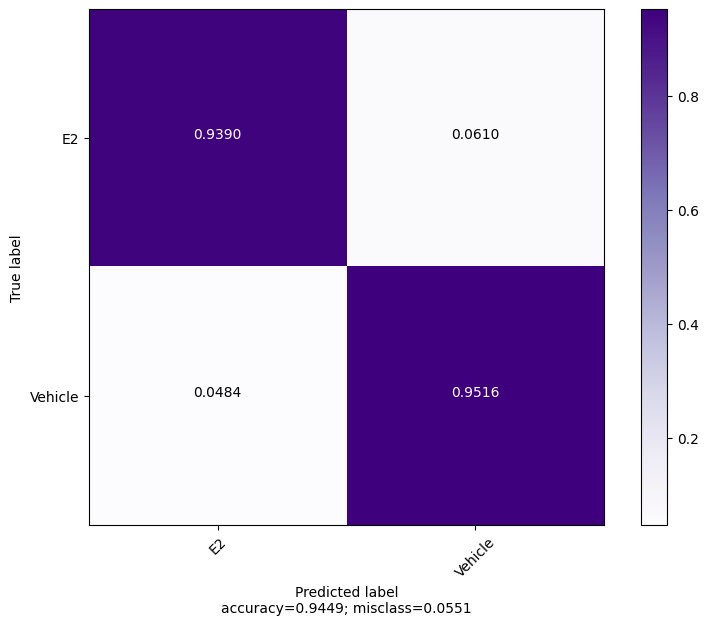

In [67]:
# Confusion matrix for performance with smallest alpha
scmkl.plot_conf_mat(results, normalize=True)

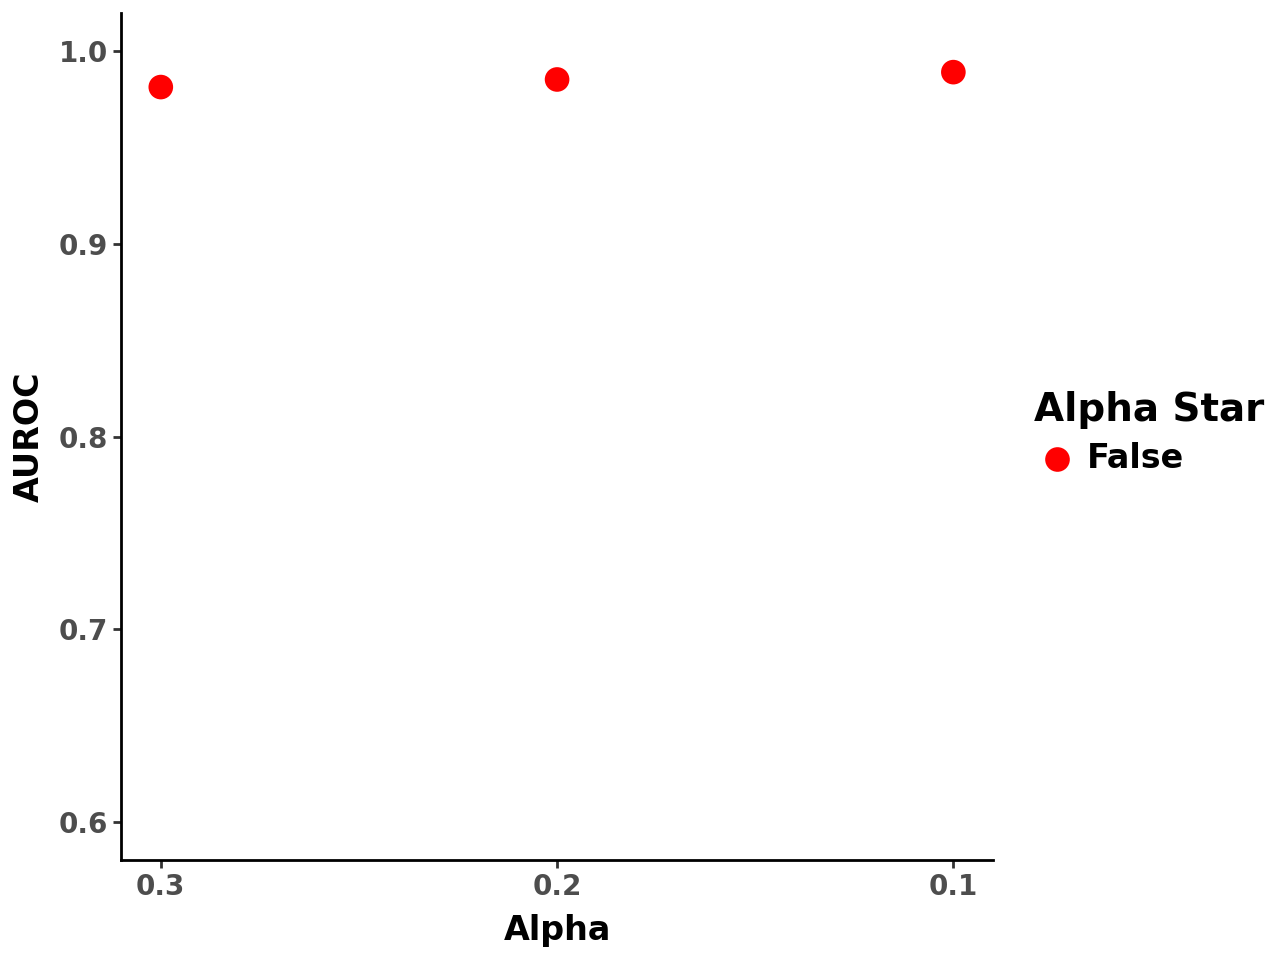

In [68]:
scmkl.plot_metric(summary)

## Interpretation

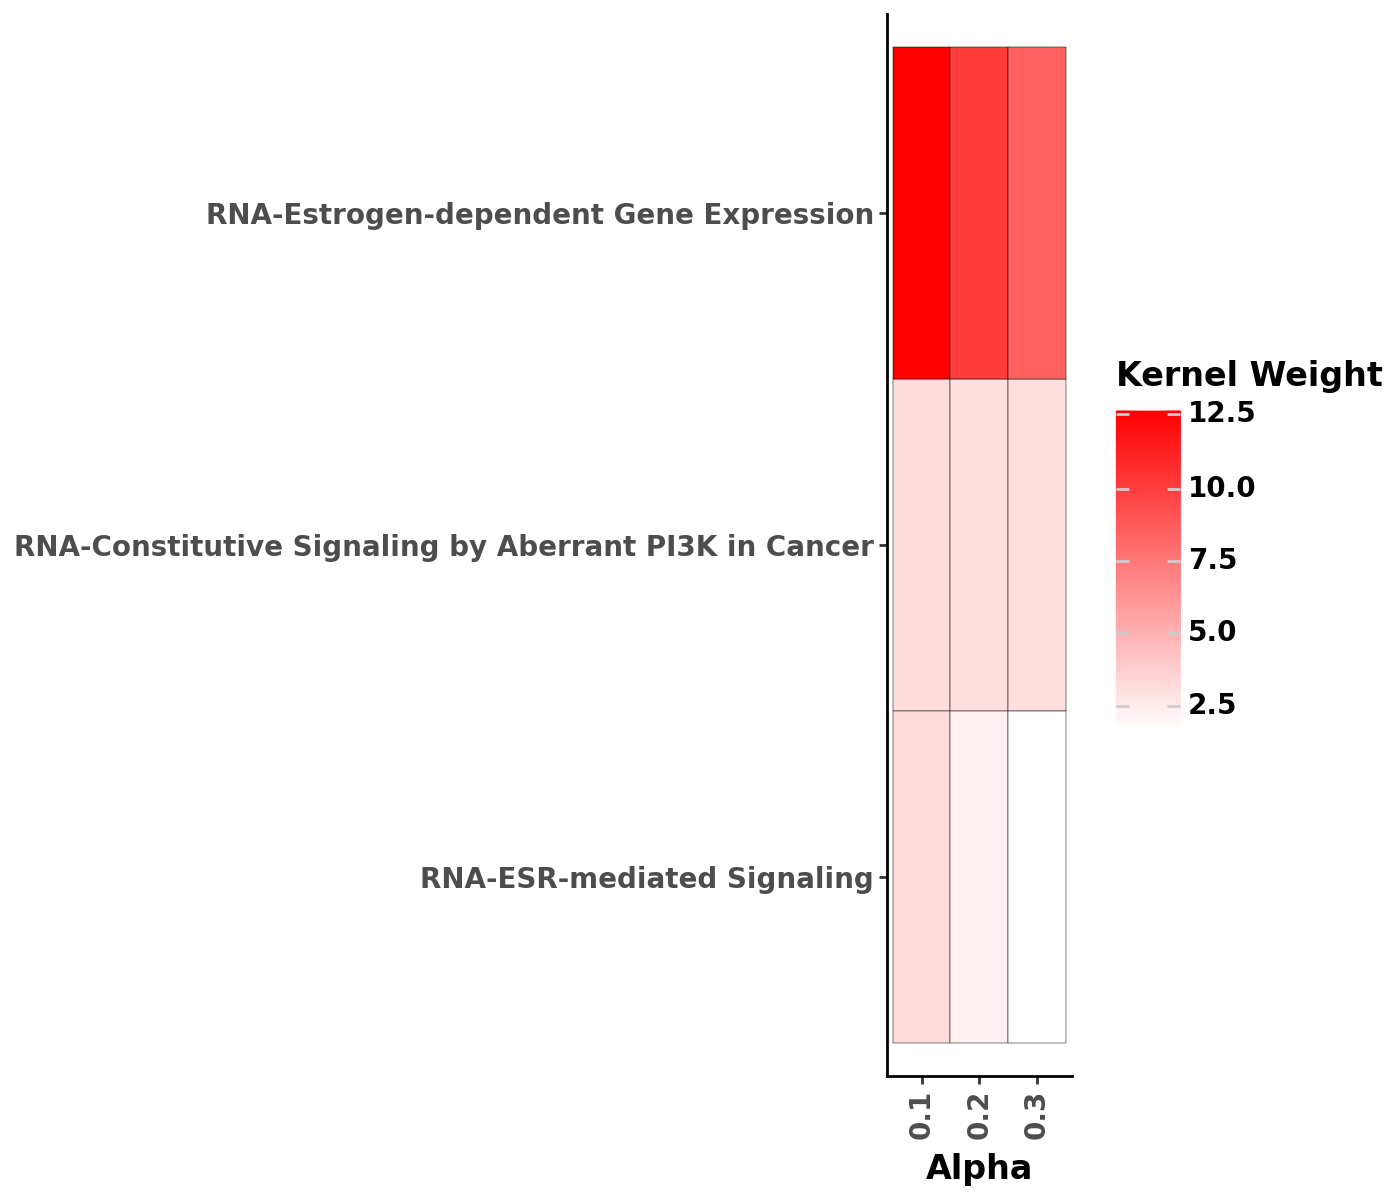

In [70]:
scmkl.weights_heatmap(results, n_groups=3, scale_weights=True)

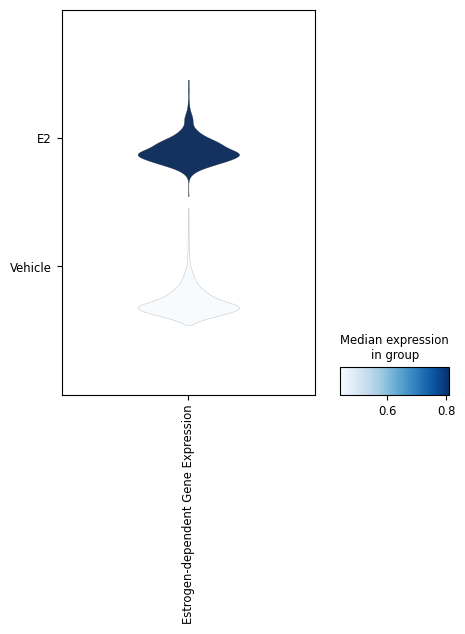

In [71]:
# Capturing top groups
top_groups = list({group[4:] for group in summary['Top Group'] if 'RNA' in group})

# adata with only test samples
test_adata = rna_adata[rna_adata.uns['test_indices']].copy()

# Calculating module scores for top groups
for group in top_groups:
    sc.tl.score_genes(test_adata, gene_groups[group], score_name=group)

sc.pl.stacked_violin(test_adata, top_groups, 'labels', figsize=(5,5))

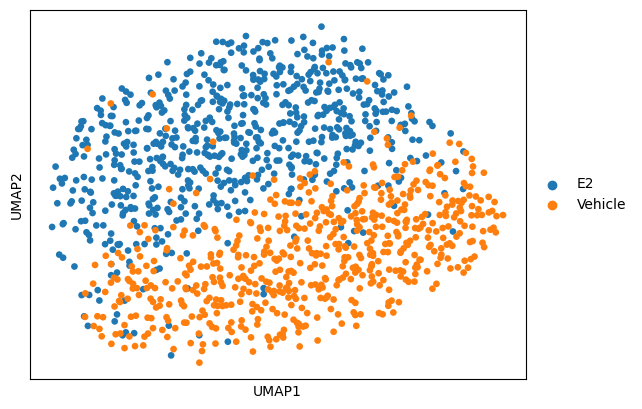

In [72]:
scmkl.group_umap(test_adata, top_groups)

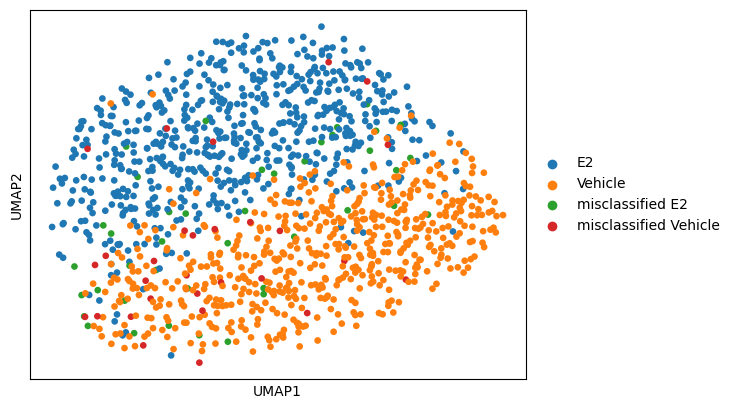

In [73]:
preds = np.array(results['Predictions'][0.1])
truth = np.array(results['Observed'])
new_labs = list()

for i, pred in enumerate(preds):
    if pred != truth[i]:
        new_labs.append(f'misclassified {truth[i]}')
    else:
        new_labs.append(pred)

scmkl.group_umap(test_adata, top_groups, labels=new_labs)
